In [1]:
import sys
import wandb
import torch
from tqdm import tqdm
sys.path.append("..")

%load_ext autoreload
%autoreload 2
import numpy as np
from gym import wrappers
from torch import nn

from matplotlib import pyplot as plt
from src import utils as utils

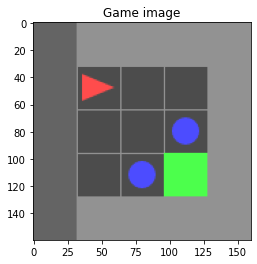

In [2]:
# env_name = "MiniGrid-DoorKey-5x5-v0"
# env_name = "MiniGrid-Empty-Random-5x5-v0"
env_name = "MiniGrid-Dynamic-Obstacles-5x5-v0"
env = utils.make_env(env_name)

obs_space_shape = env.observation_space.shape
n_actions = env.action_space.n

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

In [3]:
from src.a2c import A2CAlgo

LOG_EACH = 25
VIDEO_EACH = 400

config = {
    "time": 10,
    "n_games_mean": 1,
    "max_reward": 0.99,
    "device": "cpu",
    "env": env_name,
    "hidden_dim": 128,
    "emb_dim": 128,
    "n_env": 4,
    "gamma": 0.99,

    "max_grad_norm": 0.5,
    "lr": 0.001,
    "value_loss_coef": 0.5,
    "entropy_coef": 0.01,

    "n_sub": 1,
    "train_n_master": 4,
    "train_n_sub": 100,
    "master_step_size": 5,
    "master_time": 4,
    "sub_lr": 1e-3,
    "master_lr": 1e-3,

    "n_iter_epoch": 50,
    "n_steps_sub": 16
}

In [4]:
# import os
# os.environ["WANDB_MODE"] = "dryrun"
from src.mlsh_model import MLSHAgent
from src.env_pool import MLSHPool

agent = MLSHAgent(
    config["n_sub"],
    n_actions,
    obs_space_shape[1]
)
for p in agent.parameters():
    nn.init.uniform_(p, -0.1, 0.1)

pool = MLSHPool(agent,
                lambda : utils.make_env(env_name),
                config["n_env"],
                random_reset=True)

wandb.init(project="mlsh",
           monitor_gym=True,
           name=f"a2c_{env_name[9:]}+{config['n_sub']}",
           config=config,
           dir="..",
           magic=True,
           group="comparing")
wandb.watch(agent)

In [5]:
a2c_subpolicies = \
    A2CAlgo(agent.subpolicies.parameters(),
            config["device"],
            n_actions,
            config["gamma"],
            config["max_grad_norm"],
            config["entropy_coef"],
            config["sub_lr"],
            config["value_loss_coef"])

ac2_master = None

In [ ]:
from src import mlsh_algo
for i in tqdm(range(4000)):
    epoch_rew = mlsh_algo.common_train(
        a2c_subpolicies, pool,
        config["n_iter_epoch"],
        config["n_steps_sub"])[0]
    with torch.no_grad():
        reward, step_counter, master_hist = \
            utils.evaluate(agent, env, n_games=5)
    wandb.log({
        "mean_rewards_epoch": epoch_rew,
        "evaluate_reward": np.mean(reward)
    })

 20%|██        | 808/4000 [2:23:46<10:50:59, 12.24s/it]